In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

In [ ]:
import prophet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import OneClassSVM
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')

In [ ]:
train_data.head(5)

,DATETIME,SERVER,CPU,CPULOAD
0,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-0,3.88
1,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-1,11.33
2,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-10,5.31
3,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-11,5.25
4,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-12,0.28


In [ ]:
train_data.shape

(312696, 4)

In [ ]:
train_data['DATETIME'] = pd.to_datetime(train_data['DATETIME'], utc=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312696 entries, 0 to 312695
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   DATETIME  312696 non-null  datetime64[ns, UTC]
 1   SERVER    312696 non-null  object             
 2   CPU       312696 non-null  object             
 3   CPULOAD   312696 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(2)
memory usage: 9.5+ MB


In [ ]:
train_data = train_data.rename(columns={'DATETIME': 'ds', 'CPULOAD': 'y'})

In [ ]:
train_data['ds'] = train_data['ds'].dt.tz_localize(None)

In [ ]:
train_data = train_data.drop(columns = ['SERVER', 'CPU'] )

In [ ]:
train_data = train_data.groupby('ds', as_index = False).mean()

In [ ]:
train_data

,ds,y
0,2020-03-23 21:00:00,5.754583
1,2020-03-23 21:15:00,5.459167
2,2020-03-23 21:30:00,4.789583
3,2020-03-23 21:45:00,4.502500
4,2020-03-23 22:00:00,4.290208
...,...,...
6519,2020-05-30 19:45:00,11.573125
6520,2020-05-30 20:00:00,8.643958
6521,2020-05-30 20:15:00,8.140000
6522,2020-05-30 20:30:00,7.813750


In [ ]:
model = Prophet()
model.fit(train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9l444n0m/nctinbpt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9l444n0m/35o4zxt9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64269', 'data', 'file=/tmp/tmp9l444n0m/nctinbpt.json', 'init=/tmp/tmp9l444n0m/35o4zxt9.json', 'output', 'file=/tmp/tmp9l444n0m/prophet_model6nqte9an/prophet_model-20230712183804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = list()

for i in range (1, 31):
  date = '2020-03-%02d 21:00:00' % i
  future.append(date)

future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])
future

,ds
0,2020-03-01 21:00:00
1,2020-03-02 21:00:00
2,2020-03-03 21:00:00
3,2020-03-04 21:00:00
4,2020-03-05 21:00:00
5,2020-03-06 21:00:00
6,2020-03-07 21:00:00
7,2020-03-08 21:00:00
8,2020-03-09 21:00:00
9,2020-03-10 21:00:00


In [ ]:
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

                    ds      yhat  yhat_lower  yhat_upper
0  2020-03-01 21:00:00  6.416089    4.040400    9.173217
1  2020-03-02 21:00:00  7.129050    4.450079    9.582081
2  2020-03-03 21:00:00  7.591522    5.119237   10.209984
3  2020-03-04 21:00:00  7.630279    4.908468   10.164419
4  2020-03-05 21:00:00  7.564673    4.811910   10.105304
5  2020-03-06 21:00:00  6.911356    4.361769    9.608922
6  2020-03-07 21:00:00  4.495411    1.797469    7.074439
7  2020-03-08 21:00:00  6.314663    3.711238    9.104622
8  2020-03-09 21:00:00  7.027624    4.165157    9.543722
9  2020-03-10 21:00:00  7.490096    4.845633   10.240749
10 2020-03-11 21:00:00  7.528853    4.909326   10.113177
11 2020-03-12 21:00:00  7.463246    4.939835   10.092029
12 2020-03-13 21:00:00  6.809930    4.210255    9.419548
13 2020-03-14 21:00:00  4.393985    1.798405    7.172466
14 2020-03-15 21:00:00  6.213237    3.690657    8.696665
15 2020-03-16 21:00:00  6.926198    4.175870    9.515290
16 2020-03-17 21:00:00  7.38867

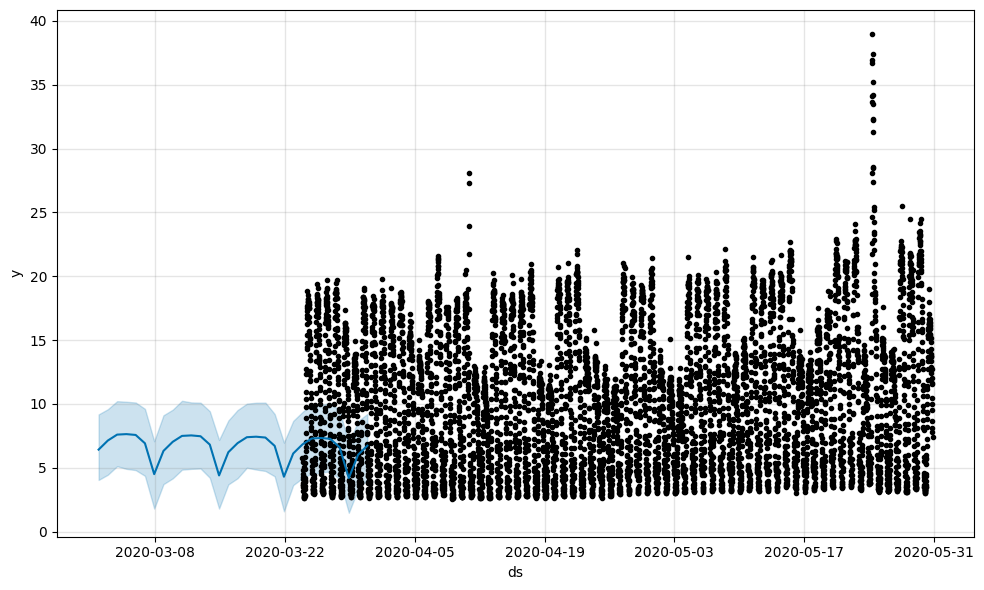

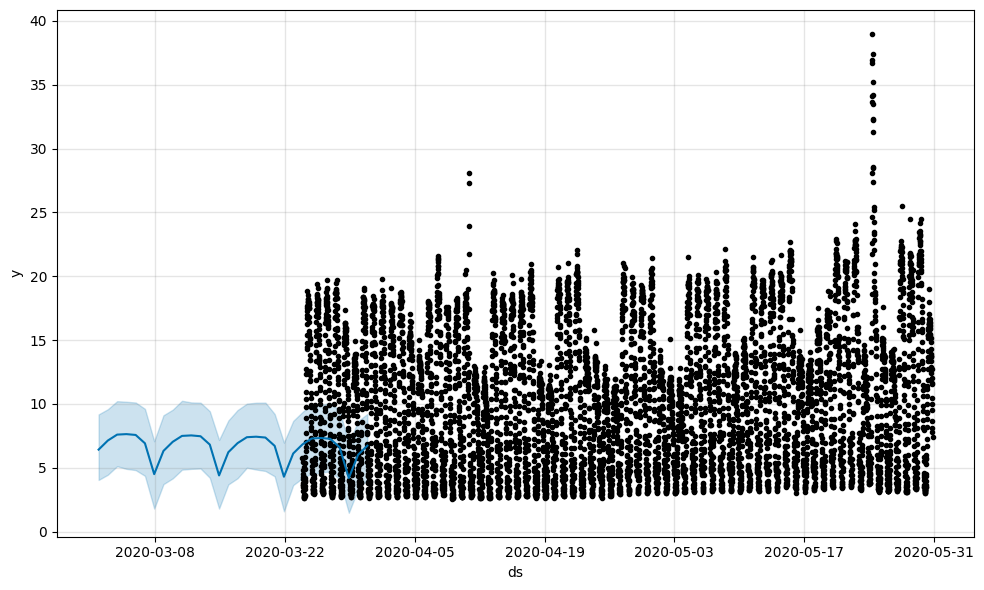

In [ ]:
model.plot(forecast)

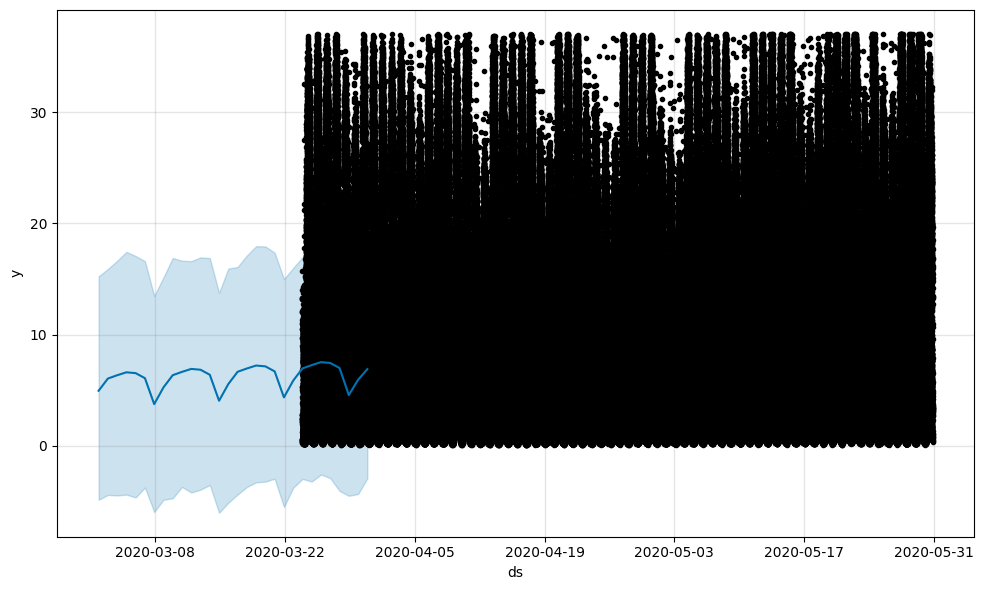

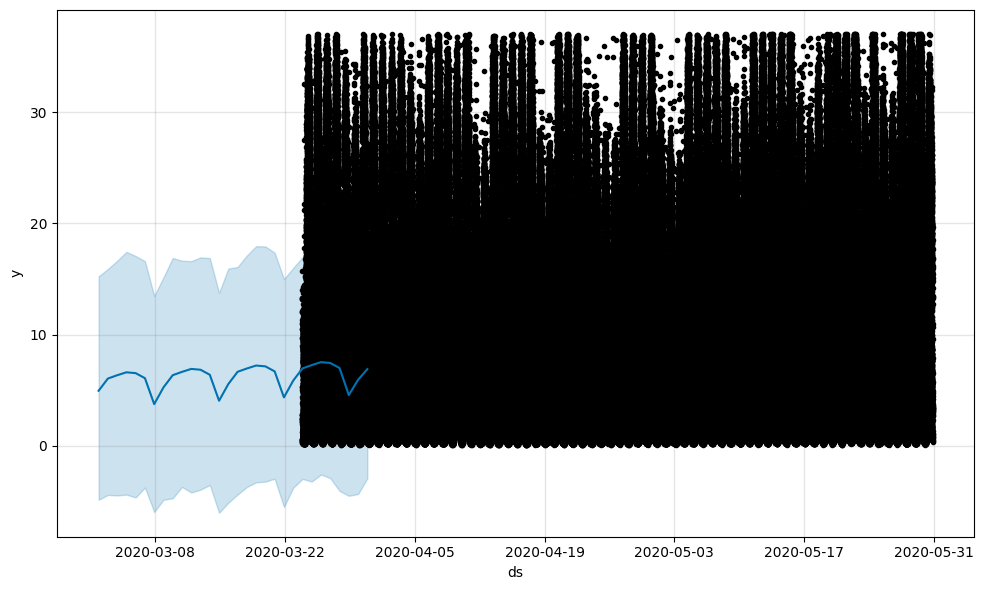

In [ ]:
model.plot(forecast)

In [ ]:
train_data_cpuload = train_data['y']
train_data_cpuload

0        5.754583
1        5.459167
2        4.789583
3        4.502500
4        4.290208
          ...    
6519    11.573125
6520     8.643958
6521     8.140000
6522     7.813750
6523     7.402083
Name: y, Length: 6524, dtype: float64

<Axes: xlabel='y'>

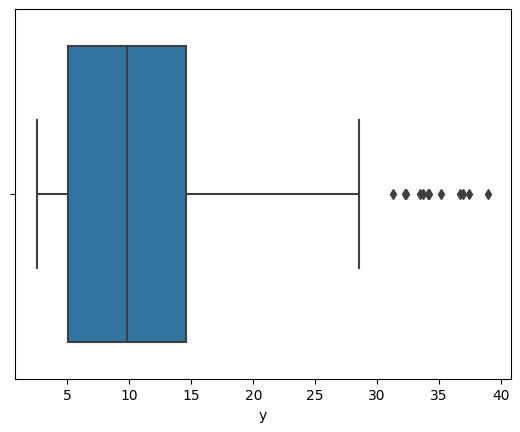

In [ ]:
sns.boxplot(x = train_data_cpuload)

In [ ]:
Q1 = train_data_cpuload.quantile(0.25)
Q3 = train_data_cpuload.quantile(0.75)
IQR = Q3 - Q1
IQR

9.532812499999999

In [ ]:
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

In [ ]:
lower_bound

-9.279843749999998

In [ ]:
upper_bound

28.851406249999997

In [ ]:
outlier_indexes = train_data_cpuload[(train_data_cpuload < lower_bound) | (train_data_cpuload > upper_bound)].index
outlier_indexes

Int64Index([5897, 5898, 5899, 5900, 5901, 5902, 5903, 5904, 5905, 5906, 5907,
            5908],
           dtype='int64')

In [ ]:
train_data = train_data.drop(labels = outlier_indexes)

In [ ]:
train_data.shape

(6512, 2)

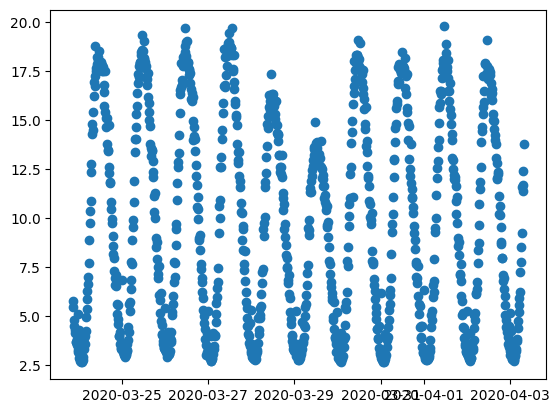

In [ ]:
plt.scatter(train_data['ds'][0:1000], train_data['y'][0:1000])
plt.show()

<Axes: >

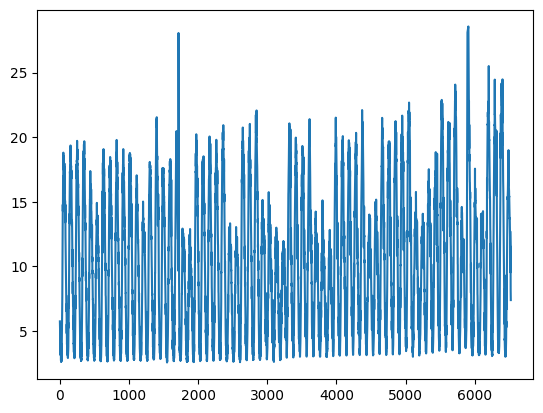

In [ ]:
train_data.y.plot()

In [ ]:
train_data.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [ ]:
train_data_copy = train_data.copy()

In [ ]:
train_data['DATETIME'] = pd.to_datetime(train_data['DATETIME'], utc=True)
train_data['Month'] = train_data['DATETIME'].dt.month
train_data['Day'] = train_data['DATETIME'].dt.day
train_data['Hour'] = train_data['DATETIME'].dt.hour
train_data['Minute'] = train_data['DATETIME'].dt.minute
train_data = train_data.drop(columns = ['DATETIME'])

In [ ]:
train_data.head(5)

,DATETIME,SERVER,CPU,CPULOAD
0,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-0,3.88
1,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-1,11.33
2,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-10,5.31
3,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-11,5.25
4,2020-03-23 21:00:00+00:00,CIHAZ_301,CPU-12,0.28


In [ ]:
train_data = train_data.drop(columns = ['CPU'])

In [ ]:
train_data = pd.get_dummies(data = train_data, columns = ['SERVER'])

In [ ]:
train_data.head(5)

,CPULOAD,Month,Day,Hour,Minute,SERVER_CIHAZ_301,SERVER_CIHAZ_305
0,3.88,3,23,21,0,1,0
1,11.33,3,23,21,0,1,0
2,5.31,3,23,21,0,1,0
3,5.25,3,23,21,0,1,0
4,0.28,3,23,21,0,1,0


In [ ]:
y = train_data['y'] # label
X = train_data.drop(columns = ['ds']) # data

In [ ]:
y.head(5)

0     3.88
1    11.33
2     5.31
3     5.25
4     0.28
Name: y, dtype: float64

In [ ]:
X.head(5)

,y
0,3.88
1,11.33
2,5.31
3,5.25
4,0.28


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [ ]:
coefficients = pd.DataFrame({'Variable': X_train.columns, 'Coefficient': regressor.coef_})
print(coefficients)

  Variable  Coefficient
0        y          1.0


In [ ]:
X_test.head(5)

,y
241219,26.32
70668,16.41
176922,23.72
127568,12.23
278130,19.80


In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([26.32, 16.41, 23.72, ...,  0.19,  4.65,  1.81])

In [ ]:
y_test

241219    26.32
70668     16.41
176922    23.72
127568    12.23
278130    19.80
          ...  
217391     9.67
243278     9.97
19425      0.19
295290     4.65
67814      1.81
Name: y, Length: 102310, dtype: float64

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE): ", mse)
print("R-squared Score: ", r2)

Mean Squared Error (MSE):  6.398553492734374e-30
R-squared Score:  1.0


In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE): ", mse)
print("R-squared Score: ", r2)

Mean Squared Error (MSE):  82.57573056459404
R-squared Score:  0.09698447555433176


In [ ]:
import statsmodels.api as sm

In [ ]:
lm = sm.OLS(y_train, X_train)

In [ ]:
model = lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.298e+35
Date:                Wed, 12 Jul 2023   Prob (F-statistic):                        0.00
Time:                        18:08:47   Log-Likelihood:                      6.3823e+06
No. Observations:              207719   AIC:                                 -1.276e+07
Df Residuals:                  207718   BIC:                                 -1.276e+07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y              1.0000   1.74e-18   5.74e+17      0.000       1.000       1.000
==============================================================================
Omnibus:                    27834.143   Durbin-Watson:                   0.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40679.966
Skew:                           1.077   Prob(JB):                         0.00
Kurtosis:                       3.237   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
test_data

,index,DATETIME,SERVER
0,0,2020-05-31 00:00:00+03:00,CIHAZ_301
1,1,2020-05-31 00:00:00+03:00,CIHAZ_305
2,2,2020-05-31 00:15:00+03:00,CIHAZ_301
3,3,2020-05-31 00:15:00+03:00,CIHAZ_305
4,4,2020-05-31 00:30:00+03:00,CIHAZ_301
...,...,...,...
187,187,2020-05-31 23:15:00+03:00,CIHAZ_305
188,188,2020-05-31 23:30:00+03:00,CIHAZ_301
189,189,2020-05-31 23:30:00+03:00,CIHAZ_305
190,190,2020-05-31 23:45:00+03:00,CIHAZ_301


In [ ]:
test_data['DATETIME'] = pd.to_datetime(test_data['DATETIME'], utc=True)

In [ ]:
test_data = test_data.rename(columns={'DATETIME': 'ds'})
test_data

,index,ds,SERVER
0,0,2020-05-30 21:00:00+00:00,CIHAZ_301
1,1,2020-05-30 21:00:00+00:00,CIHAZ_305
2,2,2020-05-30 21:15:00+00:00,CIHAZ_301
3,3,2020-05-30 21:15:00+00:00,CIHAZ_305
4,4,2020-05-30 21:30:00+00:00,CIHAZ_301
...,...,...,...
187,187,2020-05-31 20:15:00+00:00,CIHAZ_305
188,188,2020-05-31 20:30:00+00:00,CIHAZ_301
189,189,2020-05-31 20:30:00+00:00,CIHAZ_305
190,190,2020-05-31 20:45:00+00:00,CIHAZ_301


In [ ]:
test_data['ds'] = test_data['ds'].dt.tz_localize(None)
test_data

,index,ds,SERVER
0,0,2020-05-30 21:00:00,CIHAZ_301
1,1,2020-05-30 21:00:00,CIHAZ_305
2,2,2020-05-30 21:15:00,CIHAZ_301
3,3,2020-05-30 21:15:00,CIHAZ_305
4,4,2020-05-30 21:30:00,CIHAZ_301
...,...,...,...
187,187,2020-05-31 20:15:00,CIHAZ_305
188,188,2020-05-31 20:30:00,CIHAZ_301
189,189,2020-05-31 20:30:00,CIHAZ_305
190,190,2020-05-31 20:45:00,CIHAZ_301


In [ ]:
test_data = test_data.drop(columns = ['index','SERVER'])
test_data

,ds
0,2020-05-30 21:00:00
1,2020-05-30 21:00:00
2,2020-05-30 21:15:00
3,2020-05-30 21:15:00
4,2020-05-30 21:30:00
...,...
187,2020-05-31 20:15:00
188,2020-05-31 20:30:00
189,2020-05-31 20:30:00
190,2020-05-31 20:45:00


In [ ]:
y_pred = regressor.predict(test_data)
y_pred

ValueError: ignored

In [ ]:
pd.DataFrame(y_pred).to_csv('submission.csv')

In [ ]:
!zip -r '/content/submission.csv' '/content/submission'

	zip warning: missing end signature--probably not a zip file (did you
	zip warning: remember to use binary mode when you transferred it?)
	zip warning: (if you are trying to read a damaged archive try -F)

zip error: Zip file structure invalid (/content/submission.csv)
